# Pneumonia Detection 

## Project Overview 
This project involves building a convolutional neural network (CNN) to classify medical X-ray images and detect pneumonia. Targeted at beginner to intermediate-level data scientists, the project will focus on leveraging deep learning techniques to develop a robust classification model. The final model will be deployed using Streamlit, providing a user-friendly interface for real-time predictions.

### Import Libraries

In [5]:
import numpy as np 
from PIL import Image
import random as rand
import os
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Rescaling, Input
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomShear
from tensorflow.keras.optimizers import Adam 
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# What version of tensorflow are we working with? 
tf.__version__

'2.18.0'

## Week 2: Data Preprocessing

*Key Steps to Image Preprocessing*

- **Image Resizing**: ensure all images are the same size - neural networks require inputs of a fixed size


- **Pixel Normalization**: scale pixel values to take a value within a certain (smaller) range - helps model converge faster by ensuring data is consistent and not too varied


- **Data Augmentaion**: apply random transformations (e.g. rotations/flips) to images - increases the variety in the training set to prevent overfitting and increase the generalization of the model

*Techniques in Data Augmentation*

- **Geometric**: 'Modify shape/position of the image' e.g. zooming/cropping, flipping(horizontal/vertical), rotating, shifting

- **Photometric**: 'Modify appearance/color of image' e.g. altering brigthness, contrast, saturation, hue

Depending on the data available, specific techniques/transformations are used in combination. In the case of this dataset (grayscale X-ray images), I will avoid ***photometric augmentation techniques*** since pneumonia detection involves detecting **gray/white intersitial patterns** which could be obstructed/unrecognizable through certain photometric augmentation techniques by altering parameters such as brightness and contrast. 

In [7]:
test_data_dir = '../../data/chest_xray/test'
train_data_dir = '../../data/chest_xray/train'
# This is used for later validation
val_data_dir = '../../data/chest_xray/val'

### Number of images BEFORE removing from folder for corruption 

In [8]:
# How many images are we dealing with? 
for folder_name in ('NORMAL', 'PNEUMONIA'):
    folder_path = os.path.join(train_data_dir, folder_name)
    image_list = os.listdir(folder_path)
    if (folder_name == 'NORMAL'): 
        print(f'NORMAL IMAGE COUNT TRAIN SET: {len(image_list)}')
    else: 
        print(f'PNEUMONIA IMAGE COUNT TRAIN SET: {len(image_list)}')

NORMAL IMAGE COUNT TRAIN SET: 1341
PNEUMONIA IMAGE COUNT TRAIN SET: 3875


### Filter out corrupted images (if any)

In [9]:
num_skipped = 0
# Delete images based on not having JFIF in header
for folder_name in ('NORMAL', 'PNEUMONIA'):
    folder_path = os.path.join(train_data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 173 images.


### Visualize the training dataset BEFORE applying transformation

In [10]:
# How many images are we dealing with? 
for folder_name in ('NORMAL', 'PNEUMONIA'):
    folder_path = os.path.join(train_data_dir, folder_name)
    image_list = os.listdir(folder_path)
    if (folder_name == 'NORMAL'): 
        print(f'NORMAL IMAGE COUNT TRAIN SET: {len(image_list)}')
    else: 
        print(f'PNEUMONIA IMAGE COUNT TRAIN SET: {len(image_list)}')

NORMAL IMAGE COUNT TRAIN SET: 1300
PNEUMONIA IMAGE COUNT TRAIN SET: 3743


### Class Imbalance

- The above indicates that their is a class imbalance with Normal Images being the minority class

- We will need to resolve this imbalance later down the line, but will note the imbalance for now 

In [11]:
def display_image_from_path(image_path):
    """Displays an image from a specified folder path."""
    if not os.path.exists(image_path):
        print(f"Error: The file at '{image_path}' does not exist.")
        return
    
    image_name = os.path.basename(image_path) # Extract filename 
    image = Image.open(image_path)  # Open image
    plt.imshow(image)
    plt.title(image_name) # Set filename as title
    #plt.axis('off')  # Hide axis for better visualization
    plt.show()

In [12]:
normal_fpath = []
pneumonia_fpath = []

for folder_name in ('NORMAL', 'PNEUMONIA'):
    folder_path = os.path.join(train_data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if (folder_name == 'NORMAL'): 
            normal_fpath.append(fpath)
        else: 
            pneumonia_fpath.append(fpath)

In [13]:
print('NORMAL IMAGE PATH TRAIN SET')
print(normal_fpath)
print(len(normal_fpath))
print('\n')
print('PNEUMONIA IMAGE PATH TRAIN SET')
print(pneumonia_fpath)
print(len(pneumonia_fpath))

NORMAL IMAGE PATH TRAIN SET
['../../data/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0117-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0119-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0122-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0125-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0127-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0128-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0129-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0131-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0133-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0135-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0137-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0140-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0141-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0143-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-0145-0001.jpeg', '../../data/chest_xray/train\\NORMAL\\IM-01

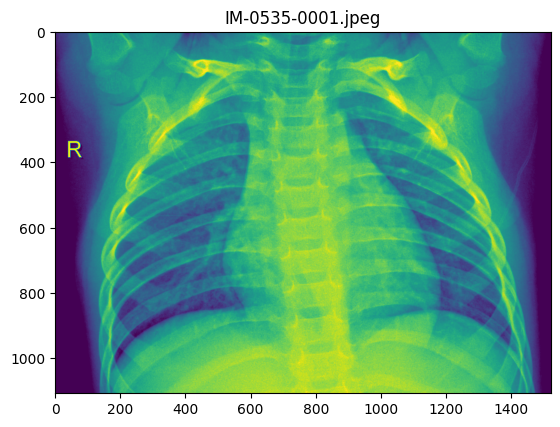

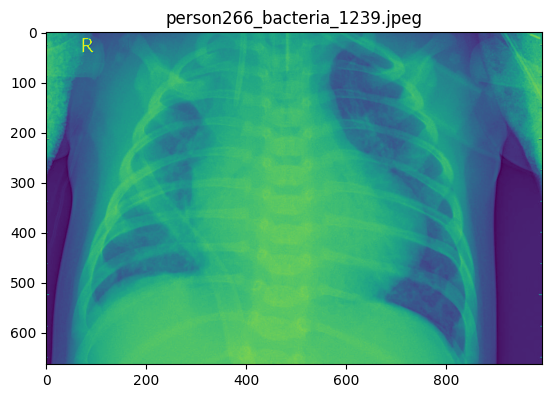

In [14]:
normal_rand_num = rand.randint(0, len(normal_fpath) - 1)
pneumonia_rand_num = rand.randint(0,len(pneumonia_fpath) - 1)

display_image_from_path(normal_fpath[normal_rand_num])
display_image_from_path(pneumonia_fpath[pneumonia_rand_num])


### Transform the images to a standard size 

In [15]:
img_height = 180
img_width = 180
batch_size = 128

# Training set 
training_set = image_dataset_from_directory(
    train_data_dir, 
    image_size=(img_height, img_width), # Resizing the images to a uniform size 
    batch_size=batch_size # How many images to have in each batch?
)

# Validation set 
validation_set = image_dataset_from_directory(
    val_data_dir,
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

# Testing set 
testing_set = image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 5043 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [16]:
# Find class names of training dataset 
class_names = training_set.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


### Handling Class Imbalance by Computing Class Weights

In [17]:
# Extract labels from dataset 
labels = []

for _, lbls in training_set: 
    labels.extend(lbls.numpy()) # Convert tensors to Numpy array 

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels), 
    y=labels 
)

# Convert to dictionary format for Tensorflow 
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.9396153846153845, 1: 0.673657493988779}


The CNN model to be built calculates a **loss function** which the model aims to minimize throughout subsequent EPOCs. With class weighting, the loss function applies **higher penalties** to misclassified samples from the *minority class* (which are the normal lungs). This handles the class imbalance by urging the model to pay more attention to the minority class (normal lungs).

### Visualize the training dataset AFTER resizing

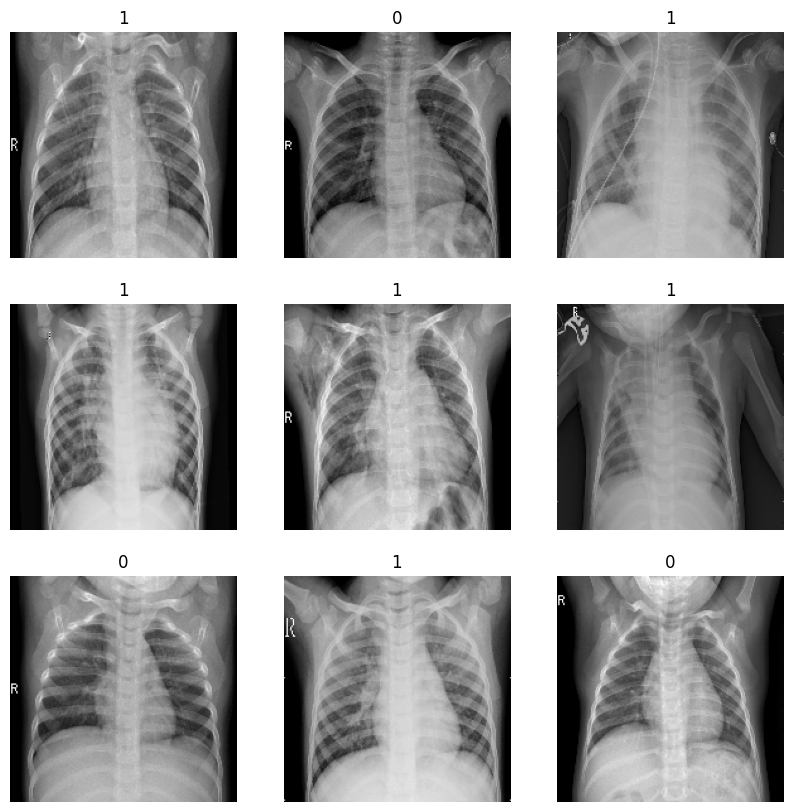

In [18]:
plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [19]:
# Print shape of the image in your training set
for image_batch, labels_batch in training_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
# image_batch: (128, 180, 180, 3) - Batch of 128 images of 180x180x3
# label_batch: (128,) - Corresponds to labels for 128 images 

(128, 180, 180, 3)
(128,)


### Apply data augmentation to the training dataset

The test set should **not be augmented** because it should reflect *real-world conditions*. The model would be tested on **altered images** that aren't actual medical scans

In [20]:
data_augmentation_layers = [
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.2), 
    RandomShear(0.2)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

### Visualize the training dataset AFTER applying data augmentation

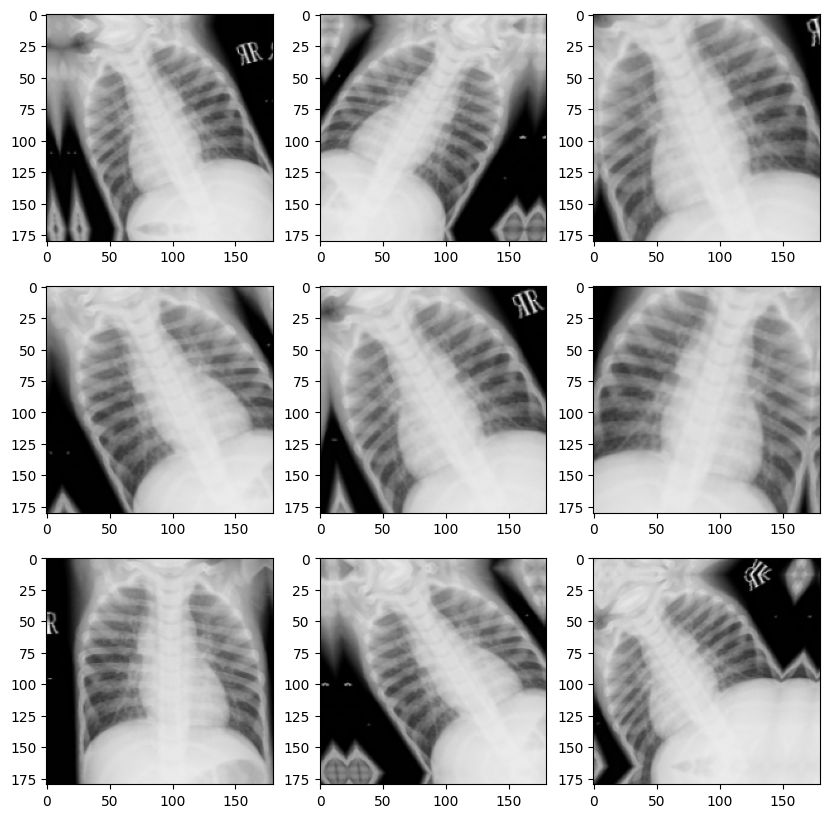

In [21]:
# Visualize these transformations
plt.figure(figsize=(10, 10))
for images, _ in training_set.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        #plt.axis("off")

*Configure Dataset for Performance*

When loading data, we need to remember about performance implications when training the model through many epochs
- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [22]:
# Performance enhancements 
AUTOTUNE = tf.data.AUTOTUNE

training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

### Normalize pixel values

In [23]:
# Rescale the images to a normal value 
normalization_layer = Rescaling(1./255)

In [24]:
# Normalize training dataset
normalized_training_set = training_set.map(lambda x, y: (normalization_layer(x), y))
train_image_batch, train_labels_batch = next(iter(normalized_training_set))
train_first_image = train_image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(train_first_image), np.max(train_first_image))

0.0 0.99980396


In [25]:
# Normalize testing dataset 
normalized_validation_set = validation_set.map(lambda x, y: (normalization_layer(x), y))
val_image_batch, val_labels_batch = next(iter(normalized_validation_set))
val_first_image = val_image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(val_first_image), np.max(val_first_image))

0.0 0.9995049


### Visualize training dataset AFTER normalizing pixel values

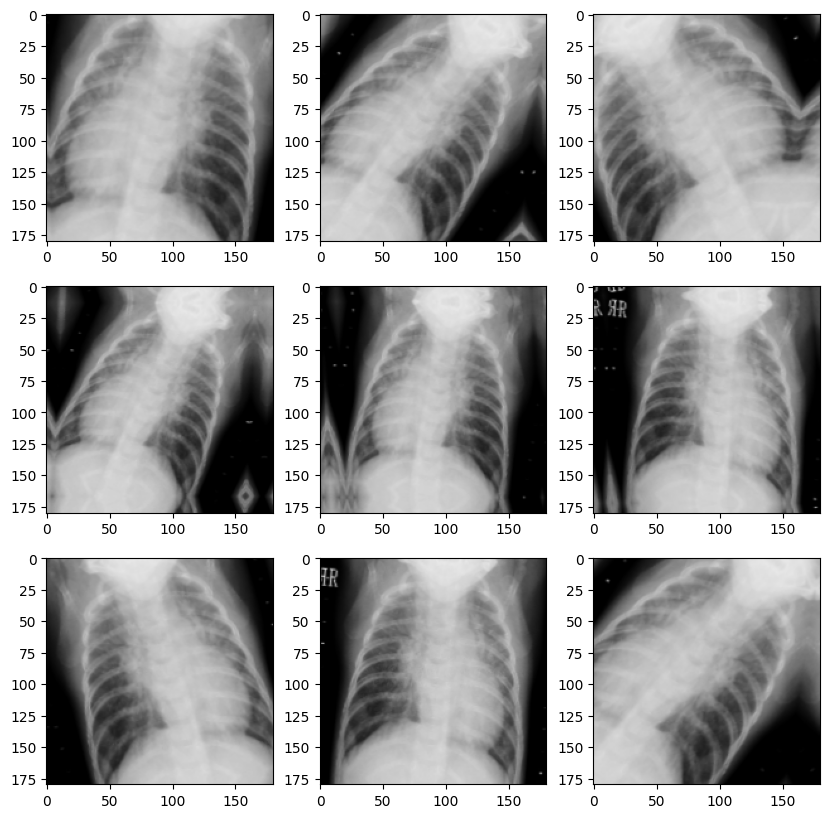

In [26]:
# Visualize these normalizations
plt.figure(figsize=(10, 10))
for images, _ in normalized_training_set.take(1):
    for i in range(9):
        if 'data_augmentation' in locals():
            augmented_images = data_augmentation(images)
            image_to_show = augmented_images[0]
        else: 
            image_to_show = images[i]

        ax = plt.subplot(3, 3, i + 1)
        # Convert back to 0-255 range for visualization
        image_to_show = np.array(image_to_show) * 255.0
        image_to_show = image_to_show.astype('uint8')
        plt.imshow(image_to_show)
        #plt.axis("off")

## Week 3: Model Development 

In [27]:
num_classes = len(class_names)
# Color images: 3 for input_shape 
# Black and white images: 2 for input_shape
input_shape = (img_height, img_width, 3) # Height, Width, Channels (RGB)

# Create model 
cnn = Sequential([
    Input(shape=input_shape) 
])

### 1 - Convolution

In [28]:
cnn.add(Conv2D(filters=32, kernel_size=3, padding='same', activation="relu"))

### 2 - Pooling

In [29]:
cnn.add(MaxPool2D(pool_size=2, strides=2))

### Add second convolutional layer

In [30]:
cnn.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
cnn.add(MaxPool2D(pool_size=2, strides=2))

### 3 - Flattening 

In [31]:
cnn.add(Flatten())

### 4 - Full connection

In [32]:
cnn.add(Dense(units=128, activation="relu"))

### 5 - Output layer

In [33]:
# Dense(units=num_classes, activation="softmax")  # Adjust for class count
cnn.add(Dense(units=1, activation='sigmoid'))

## Training the CNN Model 

### Compiling the CNN

To compile the CNN model, we need to improve the learning rate

Learning Rate - Hyperparameter of the model 

In [34]:
learning_rate = 0.001   
optimizer = Adam(learning_rate=learning_rate)

In [35]:
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# Get summary of model (view all layers of network)
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 88, 88, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,940,257 (30.29 MB)

 Trainable params: 7,940,257 (30.29 MB)

 Non-trainable params: 0 (0.00 B)

### Training the CNN on the Training Set and Evaluating on the Test Set

Let's train our model through Epochs. 

Epochs - Number of times model goes through training data

In [37]:
epochs = 10
# Train CNN on training set
history = cnn.fit(x=normalized_training_set, validation_data=normalized_validation_set, epochs=epochs, class_weight=class_weights_dict)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 494ms/step - accuracy: 0.6636 - loss: 0.8411 - val_accuracy: 0.7500 - val_loss: 0.3610
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 473ms/step - accuracy: 0.9549 - loss: 0.1183 - val_accuracy: 0.8125 - val_loss: 0.3020
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 476ms/step - accuracy: 0.9673 - loss: 0.0799 - val_accuracy: 0.9375 - val_loss: 0.2056
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 462ms/step - accuracy: 0.9820 - loss: 0.0533 - val_accuracy: 0.8125 - val_loss: 0.3300
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - accuracy: 0.9660 - loss: 0.0789 - val_accuracy: 0.8750 - val_loss: 0.2438
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - accuracy: 0.9821 - loss: 0.0445 - val_accuracy: 0.7500 - val_loss: 0.4884
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 452ms/step - accuracy: 0.9900 - loss: 0.0304 - val_accuracy: 0.6875 - val_loss: 0.7622
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 18s 444ms/step - accuracy: 0.9926 - loss: 0.0220 - val_accu

### Visualize training results 

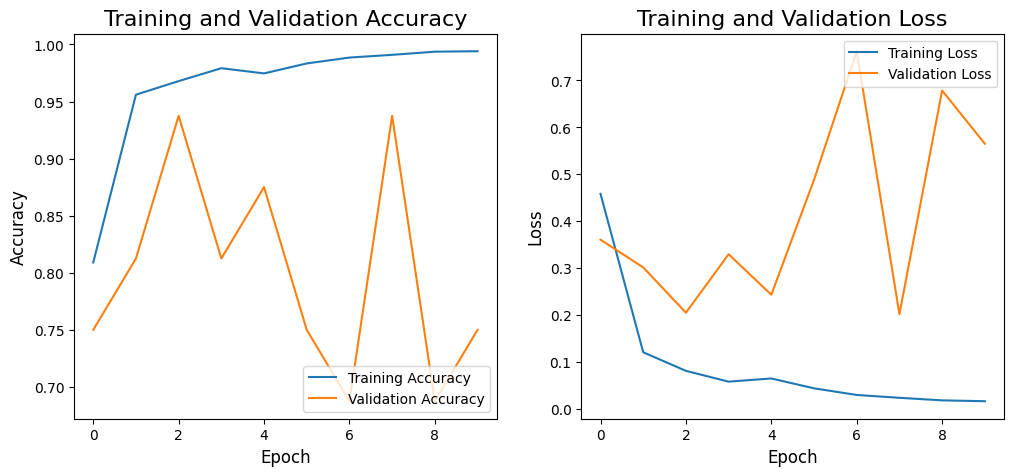

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

## Making a Single Prediction

In [39]:
# Use same size as traing 
test_image = image.load_img('../../data/chest_xray/test/PNEUMONIA/person154_bacteria_728.jpeg', target_size=(180,180))
# Convert PIL image format to an array 
test_image = image.img_to_array(test_image)
# Dimension of batch is 1st dimension
test_image = np.expand_dims(test_image, axis=0)
# Time to make predictions 
y_pred_prob = cnn.predict(test_image)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions
# Get class mapping
class_names = ['NORMAL', 'PNEUMONIA']

if (y_pred_prob[0][0] == 1): 
    prediction = class_names[1]
else: 
    prediction = class_names[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [40]:
print(f'Prediction: {prediction}')

Prediction: NORMAL


## Week 4: Model Deployment

### Save the trained model 

In [42]:
cnn.save('../../web-app/olivia-hinson/models/trained_model.keras')

### Loading the model 

In [43]:
model = load_model('../../web-app/olivia-hinson/models/trained_model.keras')

In [44]:
# Verify loaded model 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 88, 88, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,820,773 (90.87 MB)

 Trainable params: 7,940,257 (30.29 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,880,516 (60.58 MB)

# References:

- Data Augmentation Techniques: https://www.linkedin.com/advice/0/how-do-you-implement-data-augmentation-techniques
- Handling Class Imbalance in Image Classification: Techniques and Best Practices: https://medium.com/@okeshakarunarathne/handling-class-imbalance-in-image-classification-techniques-and-best-practices-c539214440b0
- Handling Class Imbalances using Class Weights: https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4
- Tensorflow Image Classification: https://www.tensorflow.org/tutorials/images/classification